Mixed effect model

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f23069989d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


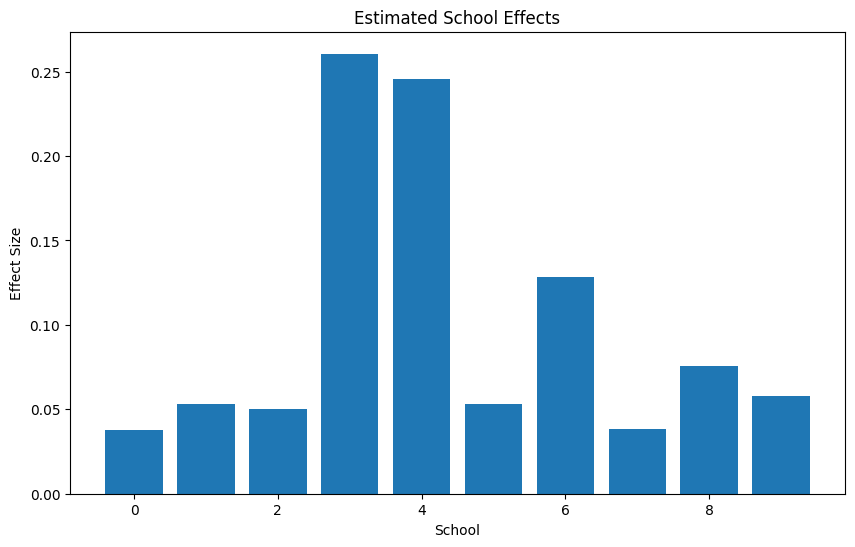

Mean squared error: 22.54
R-squared score: 0.02


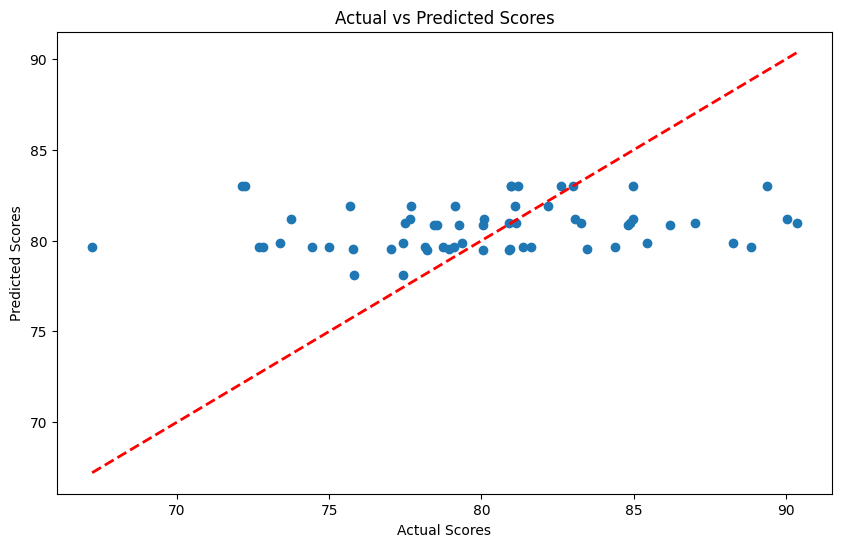

In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
n_schools = 10
n_students_per_school = 30
school_effects = np.random.normal(loc=0, scale=1, size=n_schools)
student_effects = np.random.normal(loc=0, scale=1, size=n_students_per_school * n_schools)
student_scores = np.random.normal(loc=80 + school_effects.repeat(n_students_per_school) + student_effects, scale=5)

# Create a DataFrame
data = pd.DataFrame({
    'school': np.repeat(range(n_schools), n_students_per_school),
    'score': student_scores
})

# One-hot encode the school variable
X = pd.get_dummies(data['school'], prefix='school')
y = data['score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate feature importances (which can be interpreted as school effects)
school_effects = rf_model.feature_importances_

# Plot school effects
plt.figure(figsize=(10, 6))
plt.bar(range(n_schools), school_effects)
plt.title('Estimated School Effects')
plt.xlabel('School')
plt.ylabel('Effect Size')
plt.show()

# Print model performance
from sklearn.metrics import mean_squared_error, r2_score
print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R-squared score: {r2_score(y_test, y_pred):.2f}")

# Plot actual vs predicted scores
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores')
plt.show()

Hierarchical bayesian model

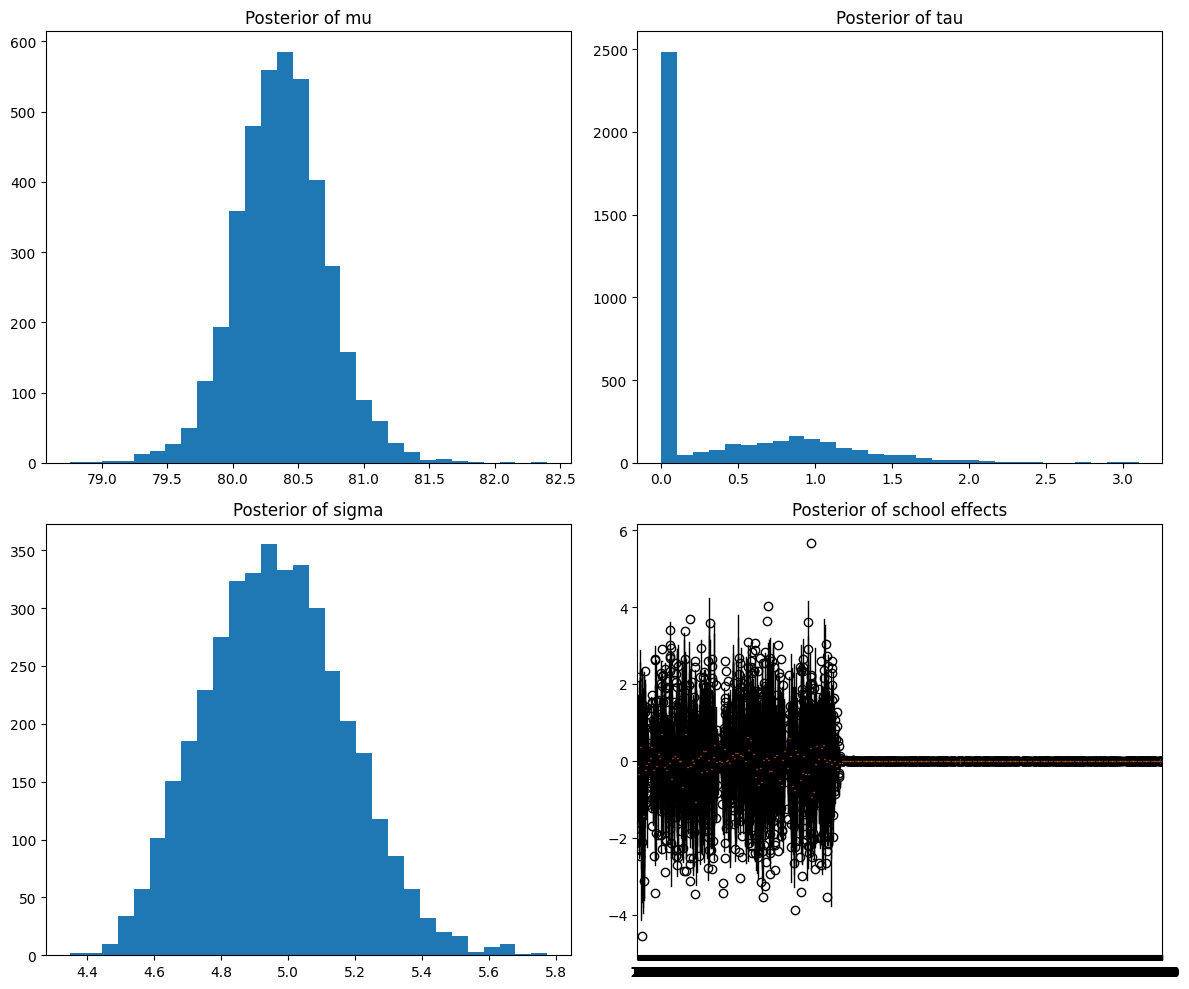

Estimated mu: 80.38 (true: 80)
Estimated tau: 0.35 (true: 1)
Estimated sigma: 4.97 (true: 5)


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
n_schools = 10
n_students_per_school = 30
true_mu = 80
true_tau = 1
true_sigma = 5

school_effects = np.random.normal(0, true_tau, n_schools)
student_scores = np.random.normal(true_mu + school_effects.repeat(n_students_per_school), true_sigma)

# Prepare data
y = student_scores
school_id = np.repeat(range(n_schools), n_students_per_school)

# Gibbs sampler
def gibbs_sampler(y, school_id, n_iter=5000, burnin=1000):
    n = len(y)
    n_schools = len(np.unique(school_id))
    
    # Initialize parameters
    mu = np.mean(y)
    tau = 1
    sigma = 1
    theta = np.zeros(n_schools)
    
    # Prepare containers for samples
    samples_mu = np.zeros(n_iter)
    samples_tau = np.zeros(n_iter)
    samples_sigma = np.zeros(n_iter)
    samples_theta = np.zeros((n_iter, n_schools))
    
    for i in range(n_iter):
        # Sample theta (school effects)
        for j in range(n_schools):
            y_j = y[school_id == j]
            n_j = len(y_j)
            theta_var = 1 / (n_j / sigma**2 + 1 / tau**2)
            theta_mean = theta_var * (np.sum(y_j - mu) / sigma**2)
            theta[j] = np.random.normal(theta_mean, np.sqrt(theta_var))
        
        # Sample mu
        mu_var = 1 / (n / sigma**2)
        mu_mean = mu_var * np.sum(y - theta[school_id]) / sigma**2
        mu = np.random.normal(mu_mean, np.sqrt(mu_var))
        
        # Sample tau
        a = n_schools / 2
        b = np.sum(theta**2) / 2
        tau = np.sqrt(1 / np.random.gamma(a, 1/b))
        
        # Sample sigma
        a = n / 2
        b = np.sum((y - mu - theta[school_id])**2) / 2
        sigma = np.sqrt(1 / np.random.gamma(a, 1/b))
        
        # Store samples
        samples_mu[i] = mu
        samples_tau[i] = tau
        samples_sigma[i] = sigma
        samples_theta[i] = theta
    
    return samples_mu[burnin:], samples_tau[burnin:], samples_sigma[burnin:], samples_theta[burnin:]

# Run Gibbs sampler
samples_mu, samples_tau, samples_sigma, samples_theta = gibbs_sampler(student_scores, school_id)

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].hist(samples_mu, bins=30)
axs[0, 0].set_title('Posterior of mu')
axs[0, 1].hist(samples_tau, bins=30)
axs[0, 1].set_title('Posterior of tau')
axs[1, 0].hist(samples_sigma, bins=30)
axs[1, 0].set_title('Posterior of sigma')
axs[1, 1].boxplot(samples_theta.T)
axs[1, 1].set_title('Posterior of school effects')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Estimated mu: {np.mean(samples_mu):.2f} (true: {true_mu})")
print(f"Estimated tau: {np.mean(samples_tau):.2f} (true: {true_tau})")
print(f"Estimated sigma: {np.mean(samples_sigma):.2f} (true: {true_sigma})")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
def create_vectors(mu, tau, sigma, theta, n_samples):
    vectors = []
    for _ in range(n_samples):
        vector = []
        for i in range(n_schools):
            # Unit node 'a'
            vector.append(np.random.normal(mu, sigma))
            # Subunit node 'b'
            vector.append(np.random.normal(mu + theta[i], sigma))
            # Unit node 'c'
            vector.append(np.random.normal(mu, sigma))
            # Subunit node 'd'
            vector.append(np.random.normal(mu + theta[i], sigma))
            # Unit node 'e'
            vector.append(np.random.normal(mu, sigma))
        vectors.append(vector)
    return np.array(vectors)


In [ ]:
# Create vectors from original sampling
original_vectors = create_vectors(true_mu, true_tau, true_sigma, school_effects, n_samples=1000)

# Create vectors from new sampling (using posterior means)
new_vectors = create_vectors(np.mean(samples_mu), np.mean(samples_tau), np.mean(samples_sigma), np.mean(samples_theta, axis=0), n_samples=1000)

# Combine datasets and create labels
X = np.vstack((original_vectors, new_vectors))
y = np.array([0]*1000 + [1]*1000)  # 0 for original, 1 for new

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Plot feature importances
feature_names = [f"{node}{i+1}" for i in range(n_schools) for node in ['a', 'b', 'c', 'd', 'e']]
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()